In [149]:
# Pre-processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.utils import class_weight

# Machine Learning / hyperparameter tuning
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import cross_val_predict, StratifiedKFold, GridSearchCV

# Metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, log_loss, recall_score, precision_score, f1_score

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Refresh content from drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
df_train = pd.read_csv('drive/My Drive/Colab Notebooks/df_train_processed')
df_test = pd.read_csv('drive/My Drive/Colab Notebooks/df_test_processed')

In [ ]:
print(df_train.shape)
df_test.shape

(3316, 5)


(5667, 4)

In [ ]:
# Splitting training data
df_train_X = df_train.drop('Class', axis = 1)
df_train_y = df_train['Class']

In [ ]:
# Joining train_x with test data to extract features
df_new = pd.concat([df_train_X, df_test], ignore_index=True)

In [ ]:
df_new.shape

(8983, 4)

# **Categorical Features**

### One-Hot Encoding

In [ ]:
df_dummy = df_new[['Gene', 'Variation']]
df_dummy = pd.get_dummies(df_dummy)

In [ ]:
df_dummy.head()

,Gene_A4GALT,Gene_AAAS,Gene_AANAT,Gene_AARS,Gene_ABCA1,Gene_ABCA12,Gene_ABCA3,Gene_ABCA4,Gene_ABCB11,Gene_ABCB7,Gene_ABCC11,Gene_ABCC2,Gene_ABCC6,Gene_ABCC8,Gene_ABCC9,Gene_ABCD1,Gene_ABCG5,Gene_ABCG8,Gene_ABHD5,Gene_ABL1,Gene_ACAD8,Gene_ACADL,Gene_ACADM,Gene_ACADS,Gene_ACADSB,Gene_ACADVL,Gene_ACAT1,Gene_ACOX1,Gene_ACSL4,Gene_ACTN4,Gene_ACVR1,Gene_ACVR2B,Gene_ACVRL1,Gene_ADA,Gene_ADAMTS10,Gene_ADAMTS13,Gene_ADAMTSL2,Gene_ADGRG1,Gene_ADGRV1,Gene_ADIPOQ,...,Variation_Y856H,Variation_Y85H,Variation_Y87C,Variation_Y87N,Variation_Y88C,Variation_Y897S,Variation_Y901C,Variation_Y90H,Variation_Y913C,Variation_Y931C,Variation_Y97C,Variation_Y98H,Variation_Y98N,Variation_Y99C,Variation_YAP1-FAM118B Fusion,Variation_YAP1-MAMLD1 Fusion,Variation_YAP1-TFE3 Fusion,Variation_YWHAE-ROS1 Fusion,Variation_ZC3H7B-BCOR Fusion,Variation_ZNF198-FGFR1 Fusion,Variation_null129R,Variation_null1313Y,Variation_null154R,Variation_null189Y,Variation_null262Q,Variation_null267R,Variation_null281E,Variation_null293R,Variation_null330W,Variation_null373C,Variation_null380R,Variation_null399R,Variation_null420W,Variation_null423L,Variation_null462G,Variation_null483L,Variation_null496R,Variation_null522S,Variation_null654G,Variation_p61BRAF
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# **Text Feature**

### Term Frequency-Inverse Document Frequency (TF-IDF)

In [ ]:
tfidf = TfidfVectorizer()
tfidf_features = tfidf.fit_transform(df_new['Text'])

svd = TruncatedSVD(n_components=500, n_iter=5, random_state=0)
truncated_tfidf = svd.fit_transform(tfidf_features)
features_name = ["tfidf_"+str(i) for i in range(500)]

df_tfidf = pd.DataFrame(truncated_tfidf)
df_tfidf.columns = features_name

In [ ]:
df_tfidf.shape

In [ ]:
df_tfidf.head()

# **Joining Categorical (dummies) with Text (tf-idf) Features**

In [ ]:
# Creating Id
df_dummy['ID'] = [i for i in range(len(df_dummy))]
df_tfidf['ID'] = [i for i in range(len(df_tfidf))]

In [ ]:
df_enc = df_dummy.join(df_tfidf.set_index('ID'), on='ID')

In [ ]:
del df_new['ID']

In [ ]:
df_enc.head()

### **Splitting Data**

In [ ]:
df_train_X = df_enc.iloc[:3316, :]
df_test_X = df_enc.iloc[3316:, :] 

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(df_train_X, df_train_y, test_size=0.33, random_state=0)

# **Training Models**

In [145]:
def evaluation(test_X, test_y, pred_y, pred_y_2, model, name):

    print(name,': ',model.best_params_)

    print('log loss: {}'.format(log_loss(test_y, pred_y)))
    print('precision: {}'.format(precision_score(test_y, pred_y_2, average='weighted')))
    print('recall: {}'.format(recall_score(test_y, pred_y_2, average='weighted')))
    print('f1-score: {}'.format(f1_score(test_y, pred_y_2, average='weighted')))

    # Plotting confusion matrix
    disp = plot_confusion_matrix(model, test_X, test_y,
                                 display_labels=[1, 2, 3, 4, 5, 6, 7, 8, 9],
                                 cmap=plt.cm.Blues)
    disp.ax_.set_title('Confusion Matrix')
    print(disp.confusion_matrix)

In [166]:
def random_forest(train_X, test_X, train_y, test_y):

    param = [{'n_estimators':[100, 250, 500],'max_features': ['sqrt']}]
    model = GridSearchCV(RandomForestClassifier(n_jobs=-1, random_state=0, class_weight='balanced'), param, cv=StratifiedKFold(random_state=0))
    model.fit(train_X, train_y)
    pred_y = model.predict_proba(test_X)
    pred_y_2 = model.predict(test_X)
    name = 'Random forest'
    
    return evaluation(test_X, test_y, pred_y, pred_y_2, model, name)

In [155]:
def svmc(train_X, test_X, train_y, test_y):

    param = [{'C': [1.0, 10]}]
    model = GridSearchCV(svm.SVC(class_weight='balanced', probability=True), param, cv=StratifiedKFold(random_state=0))
    model.fit(train_X, train_y)
    pred_y = model.predict_proba(test_X)
    pred_y_2 = model.predict(test_X)
    name = 'Support Vector Machine'

    return evaluation(test_X, test_y, pred_y, pred_y_2, model, name)

In [164]:
def lgbm(train_X, test_X, train_y, test_y):
  
    param = [{'n_estimators': [10, 50, 100], 'learning_rate': [0.05]}]
    model = GridSearchCV(LGBMClassifier(class_weight='balanced'), param, cv=3)
    model.fit(train_X, train_y)
    pred_y = model.predict_proba(test_X)
    pred_y_2 = model.predict(test_X)
    name = 'LightGBM'
		
    return evaluation(test_X, test_y, pred_y, pred_y_2, model, name)

**Random Forest**

Random forest :  {'max_features': 'sqrt', 'n_estimators': 250}
log loss: 1.4901341020450918
precision: 0.6543292036946936
recall: 0.6200913242009133
f1-score: 0.6082346746036009
[[ 91   2   0  11  10   5  42   0   0]
 [  5  58   0   1   2   1  93   0   0]
 [  1   0   9   9   3   0  16   0   0]
 [ 35   0   4 152   5   5  49   0   0]
 [ 15   3   3  11  31   1  15   0   0]
 [  3   1   2   1   7  54  15   0   0]
 [  4  16   2   0   7   3 275   0   0]
 [  0   0   0   0   0   0   4   1   2]
 [  0   0   0   0   0   0   2   0   8]]


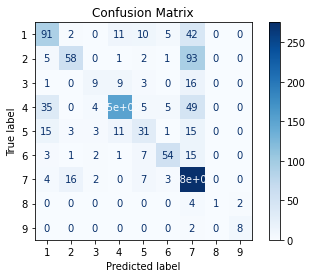

In [146]:
random_forest(train_X, test_X, train_y, test_y)

**Support Vector Machine**

Support Vector Machine :  {'C': 10}
log loss: 1.7854982979899239
precision: 0.1618246817779495
recall: 0.13515981735159818
f1-score: 0.11301757823793533
[[ 59  10  39   0  18  12  13   0  10]
 [ 40  11  41   0   8  35  10   0  15]
 [ 18   0  12   0   4   3   0   0   1]
 [ 93  10  46   0  55  14  11   0  21]
 [ 12   4  15   0   8  34   4   0   2]
 [ 13   2  14   0  16  32   5   0   1]
 [ 44  41 103   0  17  52  22   0  28]
 [  1   1   2   0   2   0   0   0   1]
 [  0   0   3   0   0   0   3   0   4]]


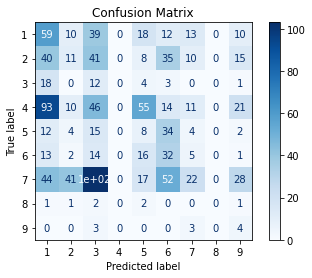

In [156]:
svmc(train_X, test_X, train_y, test_y)

LightGBM :  {'learning_rate': 0.05, 'n_estimators': 100}
log loss: 1.0191012978117187
precision: 0.6535663914823376
recall: 0.6566210045662101
f1-score: 0.6466519061889622
[[112   2   0  20   9  10   8   0   0]
 [  1  71   0   3   3   1  79   2   0]
 [  1   2   8  11   3   0  13   0   0]
 [ 43   3   6 176   6   4  12   0   0]
 [ 16   3   2  10  35   2  11   0   0]
 [  7   0   0   4   6  53  13   0   0]
 [  3  31   1   5   9   3 255   0   0]
 [  0   1   0   1   0   0   2   1   2]
 [  0   0   0   1   0   0   1   0   8]]


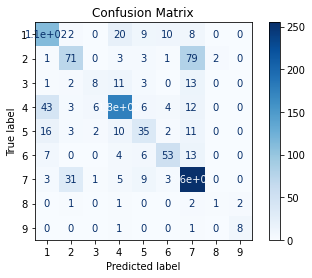

In [161]:
lgbm(train_X, test_X, train_y, test_y)

# **Predicting Test Data**

The model selected was the LightGBM with the best log loss (1.01)

In [168]:
model = LGBMClassifier(learning_rate=0.05, n_estimators=100)

In [169]:
model.fit(train_X, train_y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.05, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [170]:
pred = model.predict(df_test_X)
pred_proba = model.predict_proba(df_test_X)

In [171]:
pred.shape

(5667,)

In [172]:
pred_proba.shape

(5667, 9)

In [173]:
from sklearn import preprocessing

In [174]:
lb = preprocessing.LabelBinarizer()
lb.fit(pred)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [180]:
lb.classes_

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [181]:
pred = lb.transform(pred)

In [182]:
pred.shape

(5667, 9)

In [187]:
submmit = pd.DataFrame(pred)
submmit.columns = ['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6', 
                  'Class_7', 'Class_8', 'Class_9']

In [188]:
submmit.head()

,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,1,0,0
4,0,1,0,0,0,0,0,0,0


In [189]:
# submmit.to_csv('submission/personalized_medicine.csv', index=False)